In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

# Lectura de datos

* La primer columna representa el label o etiqueta de letra al que corresponde el vector de la 1:

In [124]:
df = pd.read_csv('emnist_short.csv')

df.shape

(100, 785)

# Creación de subconjuntos
*
* 7x7
* 10x10
* 15x15

In [125]:
def reshape_img(row, dim):
    """
        Toma el vector de la imagen original (flatten) y lo convierte a una matriz de 28x28
        Usando cv2, se usa esa matriz de 28x28 para convertirla a dimXdim
        Luego, se rota 90 grados
    """
    original = row.values.reshape(28, 28).astype(np.uint8)
    resized = cv2.resize(original, (dim, dim), interpolation=cv2.INTER_AREA)
    resized = np.rot90(resized)
    return resized

aqui se cambia el número de letras

In [126]:
def create_subset(df, tamaño, finish_index):
    subset = df.iloc[0:finish_index+1, :]
    return pd.DataFrame({
        'label': subset.iloc[:, 0],
        'image': subset.iloc[:, 1:].apply(lambda row: reshape_img(row, tamaño), axis=1)
    })

finish_index = 13

df_7 = create_subset(df, 7, finish_index)
df_10 = create_subset(df, 10, finish_index)
df_15 = create_subset(df, 15, finish_index)


In [127]:
df_7.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0], [0, 0, 38, 10, 0, 0, 0..."


In [128]:
df_10.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ..."


In [129]:
df_15.head(1)

,label,image
0,45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]..."


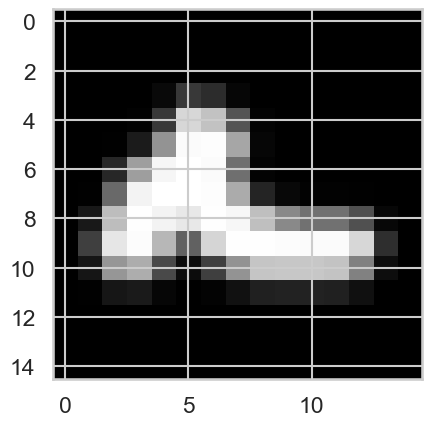

In [130]:
plt.imshow(df_15.iloc[0, 1], cmap='gray')
plt.show()

# Bipolarización de datos (-1, 1)

* Se evalúa cada pixel de la imagen y si es mayor a un thresehold se vuelve 1, de lo contrario -1

In [131]:
def make_bipolar(row, thereshold):
    return np.where(row < thereshold, -1, 1)

dfs = [df_7, df_10, df_15]
bin_dfs = []

for df in dfs:
    df_bin = pd.DataFrame({
        'label': df['label'],
        'image': df['image'].apply(make_bipolar, thereshold=40)
    })
    
    bin_dfs.append(df_bin)

dfb_7, dfb_10, dfb_15 = bin_dfs

In [132]:
dfb_15.head(1)

,label,image
0,45,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


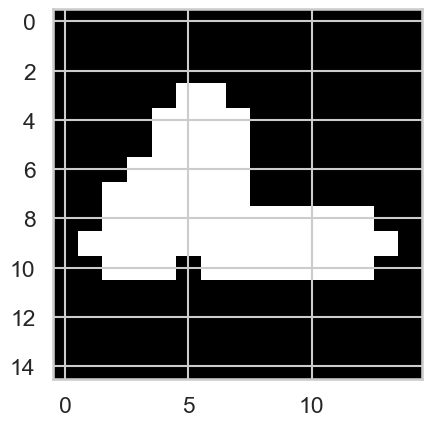

In [133]:
plt.imshow(dfb_15.iloc[0, 1], cmap='gray')
plt.show()

# 2. Red de Hopfield Sincrónica

* Se hacen los cálculos uno por uno

Se usarán los datos a partir del registro 10, de uno en uno para ver en donde comienza a fallar

In [134]:
def train_hopfield(patterns):
    n = patterns.shape[1]
    W = np.zeros((n, n))

    for pattern in patterns:
        W += np.outer(pattern, pattern)

    np.fill_diagonal(W, 0)
    
    return W

In [135]:
#weigths = []

for dfb in [dfb_7, dfb_10, dfb_15]:
    # Por cada df, obtenemos su matriz de pesos
    # train_hopfield recibe un arreglo de numpy
    # Este arreglo debe de estar aplanado y dado en una matriz bidimensional
    # Esto apra sacar el número de neuronas igual a las 
    # columnas totales de cada patrón
    dfb['flat'] = dfb['image'].apply(lambda x: np.array(x).flatten())

    #patterns = np.stack(dfb['flat'].to_numpy())
    #W = train_hopfield(patterns)

    #weigths.append(W)

#w7, w10, w15 = weigths

In [136]:
dfb_15

,label,image,flat
0,45,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,36,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,43,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,15,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,42,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
5,26,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
6,32,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
7,20,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
8,46,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9,43,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


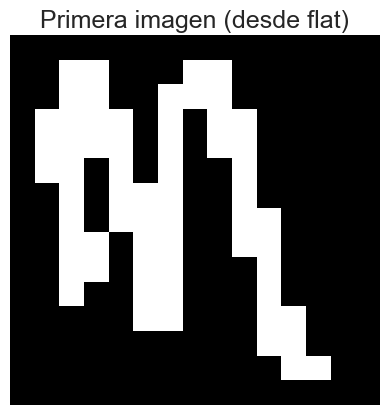

In [137]:
flat_vector = np.array(dfb_15.iloc[6]['flat'])  # Obtener el vector plano de la primera fila

# Calcular dimensión de la imagen (asumimos cuadrada)
dim = int(np.sqrt(len(flat_vector)))

# Convertir a matriz 2D
img = flat_vector.reshape((dim, dim))

# Mostrar imagen
plt.imshow(img, cmap='gray', vmin=-1, vmax=1)
plt.title("Primera imagen (desde flat)")
plt.axis('off')
plt.show()

In [138]:
def sign(x):
    return np.where(x >= 0, 1, -1)
    
def retrieve_hopfield(W, pattern, max_iter=100):

    for i in range(max_iter):
        updated = sign(W @ pattern)
        
        if np.array_equal(updated, pattern):
            break
        
        pattern = updated

    return pattern

# 3. Red Hebbiana Clásica

Se implementa una red auto-asociativa no recurrente

In [139]:
def hebb_classic_train(patterns):
    W = patterns.T @ patterns
    return W

def hebb_classic_recall(W, pattern):
    return np.sign(W @ pattern)

# 4. Experimentos de almacenamiento y ruido

In [140]:
def add_noise(pattern, noise_level):
    p = pattern.copy()
    n = len(p)

    num_flips = int(noise_level * n)
    flip_indices = np.random.choice(n, num_flips, replace=False)

    p[flip_indices] *= -1

    return p

In [141]:
def show_comparison(original_img, noisy_flat, recovered_flat, dim, n):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    titles = ["Original", "Con ruido", "Recuperado"]
    images = [
        np.array(original_img).reshape((dim, dim)),
        np.array(noisy_flat).reshape((dim, dim)),
        np.array(recovered_flat).reshape((dim, dim))
    ]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray", vmin=-1, vmax=1)
        ax.set_title(f'{title} {dim}x{dim} - {n}')
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def test_store(noise_perc):
    patterns_to_store = np.arange(start=1, stop=6, step=1)
    dfs = [
        (dfb_7, '7x7'),
        (dfb_10, '10x10'),
        (dfb_15, '15x15')
    ]
    results = []

    for noise_perc in noise_perc:
        for df, size_label in dfs:
            dim = int(size_label.split('x')[0])  # extraer el tamaño correcto

            for n in patterns_to_store:
                df_train = df.sample(n=n)
                patterns = np.stack(df_train['flat'].to_numpy())
                w = train_hopfield(patterns)

                success_count = 0
                for p in patterns:
                    noisy_flat = add_noise(p, noise_level=noise_perc)
                    recalled = retrieve_hopfield(w, noisy_flat)

                    if np.array_equal(recalled, p):
                        success_count += 1

                success_rate = success_count / n
                results.append({
                    'image_size': size_label,
                    'num_patterns': n,
                    'noise_level': noise_perc,
                    'success_rate': success_rate
                })

    results_df = pd.DataFrame(results)
    return results_df

In [142]:
results_compare = test_store(noise_perc=[0.1, 0.2, 0.3])

results_compare


,image_size,num_patterns,noise_level,success_rate
0,7x7,1,0.1,1.000000
1,7x7,2,0.1,1.000000
2,7x7,3,0.1,1.000000
3,7x7,4,0.1,0.750000
4,7x7,5,0.1,0.000000
5,10x10,1,0.1,1.000000
6,10x10,2,0.1,1.000000
7,10x10,3,0.1,0.666667
8,10x10,4,0.1,0.000000
9,10x10,5,0.1,0.000000


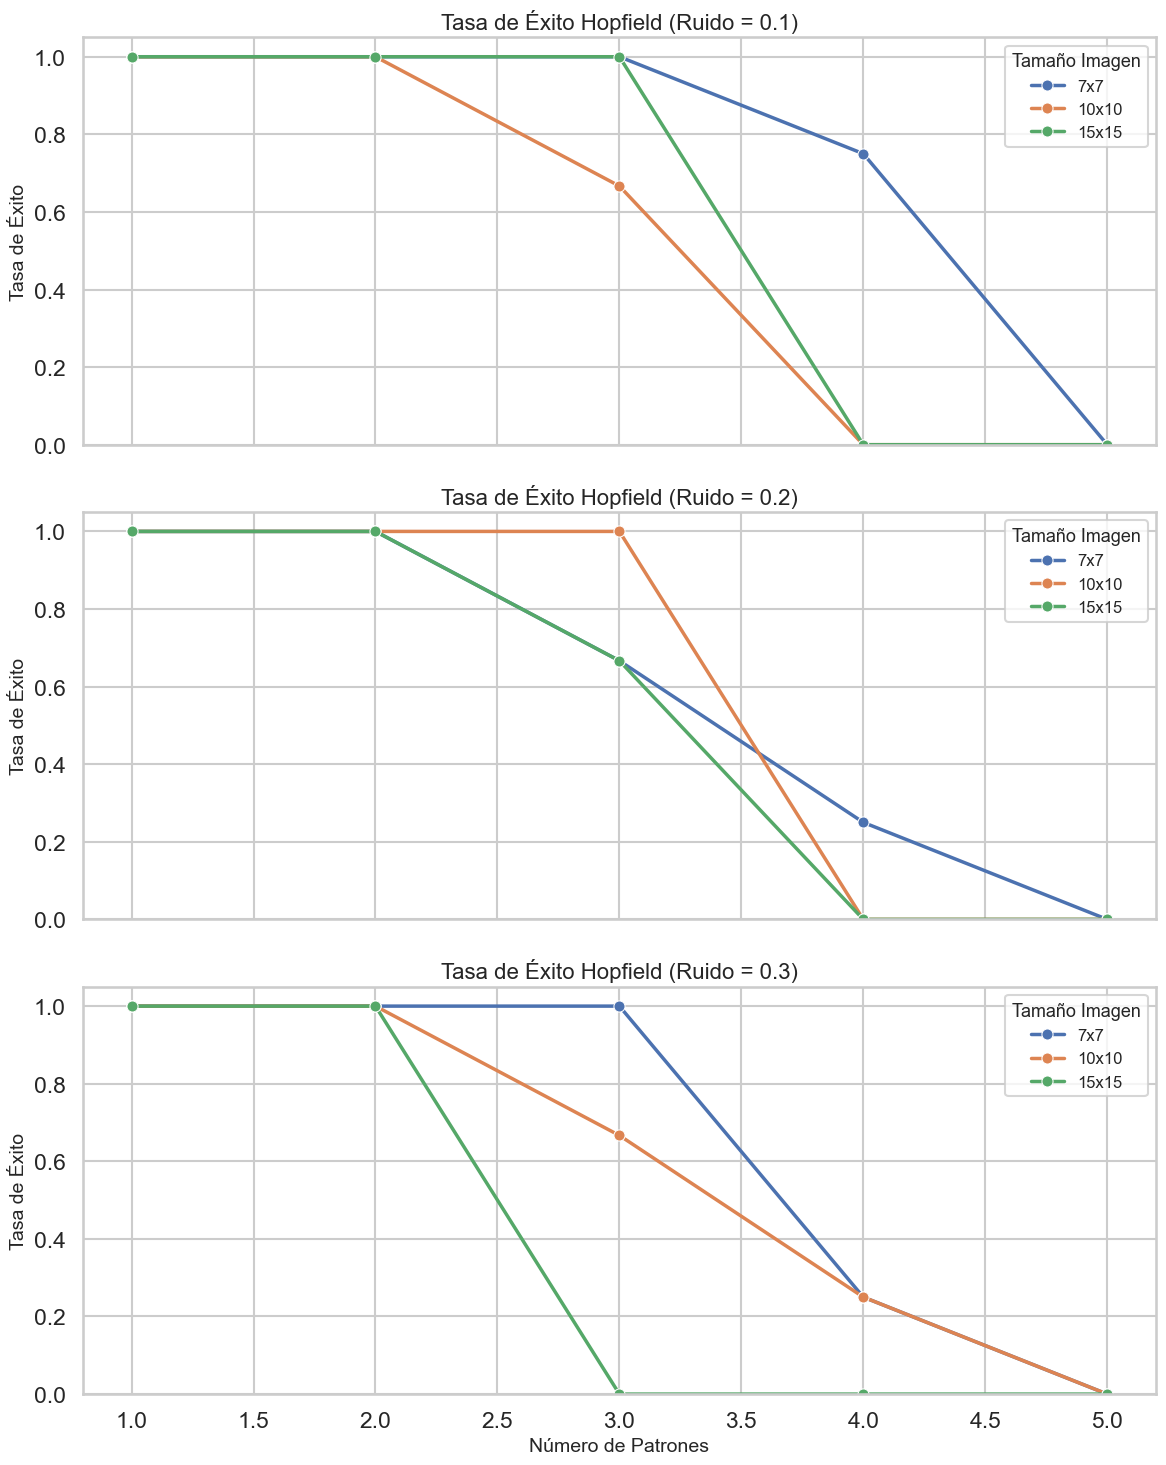

In [143]:
import seaborn as sns

def graficar_success_rate(df):
    noise_levels = sorted(df['noise_level'].unique())
    n_rows = len(noise_levels)
    
    fig, axes = plt.subplots(n_rows, 1, figsize=(12, 5 * n_rows), sharex=True)

    for ax, noise in zip(axes, noise_levels):
        df_noise = df[df['noise_level'] == noise]
        sns.lineplot(
            data=df_noise,
            x='num_patterns',
            y='success_rate',
            hue='image_size',
            marker='o',
            linewidth=2.5,
            markersize=8,
            ax=ax
        )
        ax.set_title(f'Tasa de Éxito Hopfield (Ruido = {noise})', fontsize=16)
        ax.set_xlabel('Número de Patrones', fontsize=14)
        ax.set_ylabel('Tasa de Éxito', fontsize=14)
        ax.set_ylim(0, 1.05)
        ax.grid(True)
        ax.legend(title='Tamaño Imagen', fontsize=12, title_fontsize=13)

    plt.tight_layout()
    plt.show()


graficar_success_rate(results_compare)


# 6. Comparación de Hopfield vs Clásica

* Recuperación
* Almacenamiento
* Tolerancia al ruido

In [144]:
def test_store_comparacion(noise_perc_list, repeticiones=100):
    patterns_to_store = np.arange(start=1, stop=6, step=1)
    dfs = [
        (dfb_7, '7x7'),
        (dfb_10, '10x10'),
        (dfb_15, '15x15')
    ]
    results = []

    for noise_perc in noise_perc_list:
        for df, size_label in dfs:
            dim = int(size_label.split('x')[0])

            for n in patterns_to_store:
                for method in ['Hopfield', 'Hebb']:
                    tasas = []

                    for _ in range(repeticiones):
                        df_train = df.sample(n=n)
                        patterns = np.stack(df_train['flat'].to_numpy())

                        if method == 'Hopfield':
                            W = train_hopfield(patterns)
                            recall_fn = retrieve_hopfield
                        else:
                            W = hebb_classic_train(patterns)
                            recall_fn = hebb_classic_recall

                        success_count = 0
                        for p in patterns:
                            noisy = add_noise(p, noise_level=noise_perc)
                            recalled = recall_fn(W, noisy)
                            if np.array_equal(recalled, p):
                                success_count += 1

                        tasas.append(success_count / n)

                    results.append({
                        'image_size': size_label,
                        'num_patterns': n,
                        'noise_level': noise_perc,
                        'success_rate_mean': np.mean(tasas),
                        'success_rate_std': np.std(tasas),
                        'method': method
                    })

    return pd.DataFrame(results)


# 7. Análisis Estadístico

* Medidas estadísticas
* Gráfica de tasa de recuperación vs número de patrones almacenados y nivel de ruido

In [145]:
def plot_success_rate(df):
    for size in df['image_size'].unique():
        subset = df[df['image_size'] == size]
        plt.figure(figsize=(8, 5))

        for method in subset['method'].unique():
            data = subset[subset['method'] == method].sort_values(by='num_patterns')
            x = data['num_patterns']
            y = data['success_rate_mean']
            std = data['success_rate_std']

            plt.plot(x, y, marker='o', label=method)
            plt.fill_between(x, y - std, y + std, alpha=0.2)

        plt.title(f'Tasa de éxito - Tamaño {size}')
        plt.xlabel('Número de patrones')
        plt.ylabel('Tasa de éxito')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

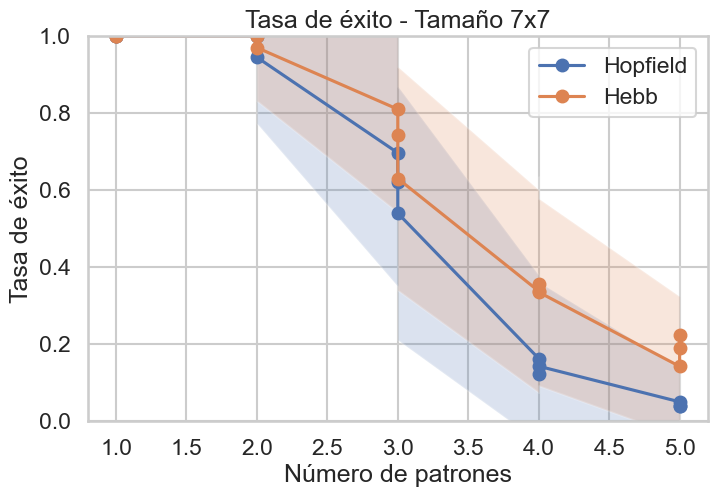

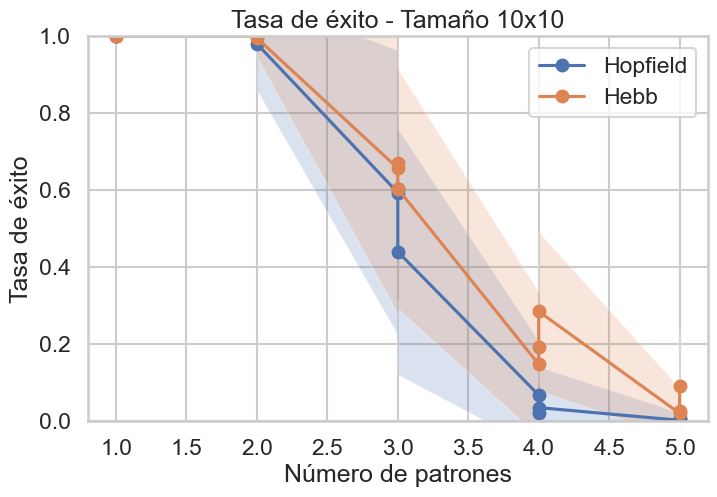

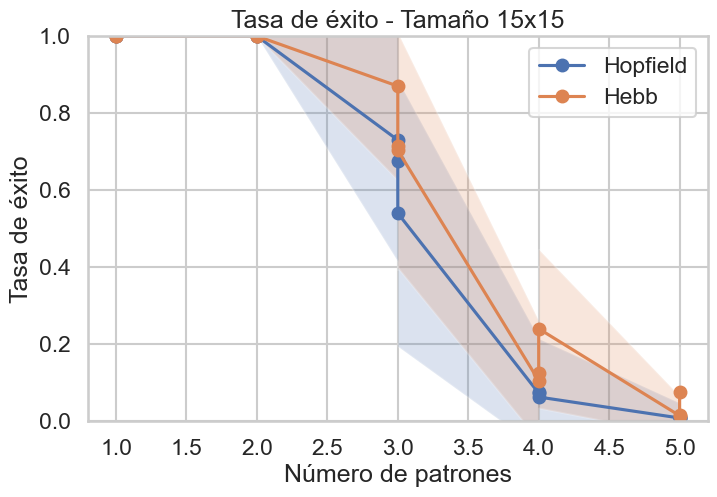

In [146]:
results_all = test_store_comparacion(noise_perc_list=[0.1, 0.2, 0.3])
plot_success_rate(results_all)


In [147]:
results_all

,image_size,num_patterns,noise_level,success_rate_mean,success_rate_std,method
0,7x7,1,0.1,1.000000,0.000000,Hopfield
1,7x7,1,0.1,1.000000,0.000000,Hebb
2,7x7,2,0.1,1.000000,0.000000,Hopfield
3,7x7,2,0.1,1.000000,0.000000,Hebb
4,7x7,3,0.1,0.696667,0.346715,Hopfield
...,...,...,...,...,...,...
85,15x15,3,0.3,0.703333,0.305123,Hebb
86,15x15,4,0.3,0.062500,0.151554,Hopfield
87,15x15,4,0.3,0.240000,0.205913,Hebb
88,15x15,5,0.3,0.008000,0.039192,Hopfield


In [148]:
summary = results_all.groupby(['method', 'image_size', 'noise_level'])[['success_rate_mean']].mean().reset_index()
summary.columns = ['Método', 'Tamaño Imagen', 'Nivel de Ruido', 'Media Éxito']

summary


,Método,Tamaño Imagen,Nivel de Ruido,Media Éxito
0,Hebb,10x10,0.1,0.564833
1,Hebb,10x10,0.2,0.577700
2,Hebb,10x10,0.3,0.594667
3,Hebb,15x15,0.1,0.597800
4,Hebb,15x15,0.2,0.570867
5,Hebb,15x15,0.3,0.603867
6,Hebb,7x7,0.1,0.657900
7,Hebb,7x7,0.2,0.657667
8,Hebb,7x7,0.3,0.631800
9,Hopfield,10x10,0.1,0.532567


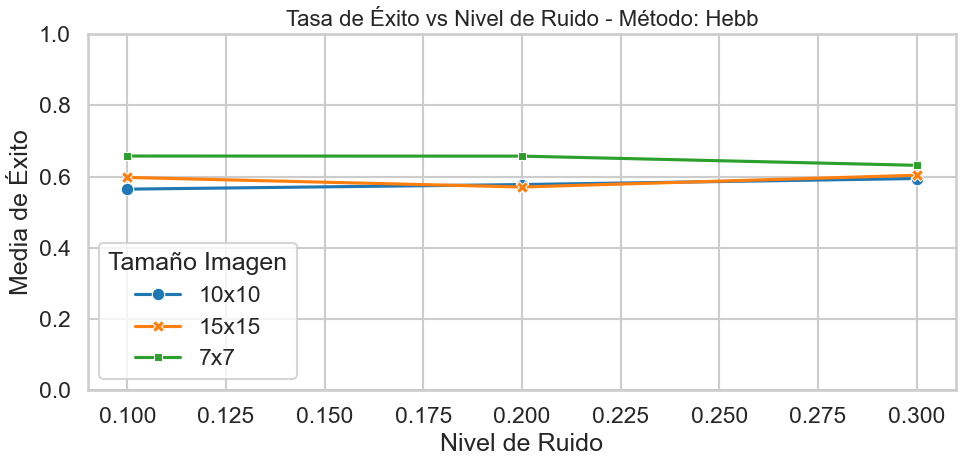

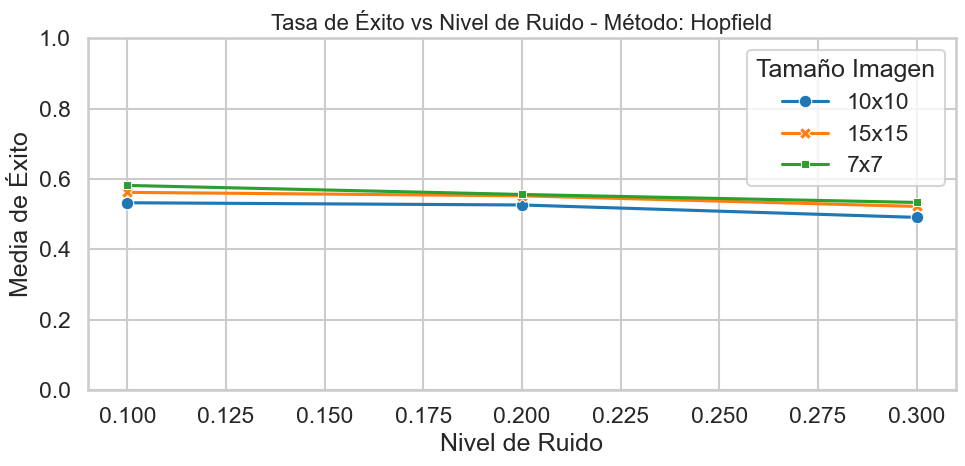

In [149]:
methods = summary['Método'].unique()
for method in methods:
    plt.figure(figsize=(10, 5))
    subset = summary[summary['Método'] == method]
    sns.lineplot(
        data=subset,
        x='Nivel de Ruido',
        y='Media Éxito',
        hue='Tamaño Imagen',
        style='Tamaño Imagen',
        markers=True,
        dashes=False,
        palette='tab10',
        legend='full'
    )
    plt.title(f'Tasa de Éxito vs Nivel de Ruido - Método: {method}', fontsize=16)
    plt.xlabel('Nivel de Ruido')
    plt.ylabel('Media de Éxito')
    plt.ylim(0, 1)
    plt.legend(title='Tamaño Imagen')
    plt.tight_layout()
    plt.show()

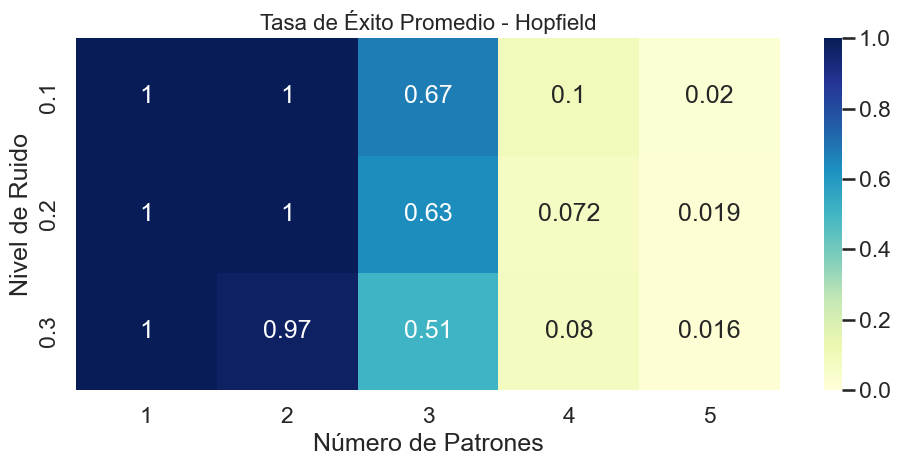

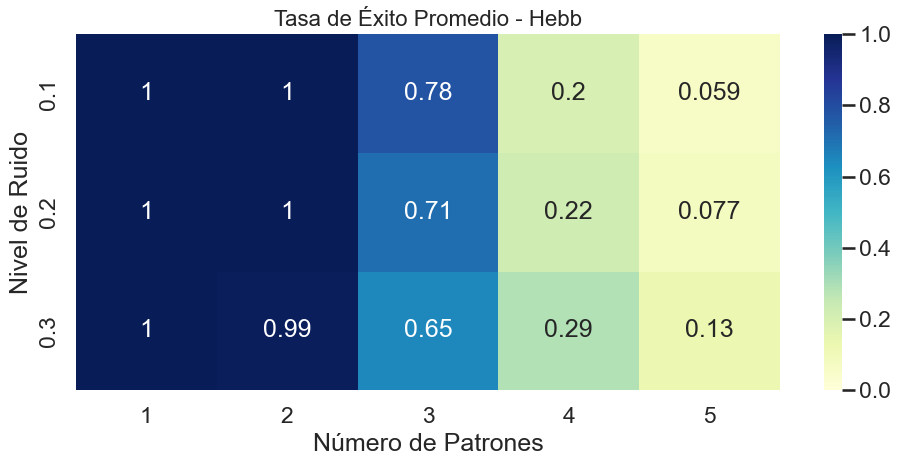

In [150]:
def heatmap_success_rate(df, method_name):
    pivot = df[df['method'] == method_name].pivot_table(
        index='noise_level',
        columns='num_patterns',
        values='success_rate_mean'
    )

    plt.figure(figsize=(10, 5))
    sns.heatmap(pivot, annot=True, cmap="YlGnBu", vmin=0, vmax=1)
    plt.title(f'Tasa de Éxito Promedio - {method_name}', fontsize=16)
    plt.xlabel('Número de Patrones')
    plt.ylabel('Nivel de Ruido')
    plt.tight_layout()
    plt.show()

heatmap_success_rate(results_all, 'Hopfield')
heatmap_success_rate(results_all, 'Hebb')


# LOS EXPERIMENTOS SE REPITEN 100 VECES

- El método **Hebb** tiene mejor tasa de éxito que **Hopfield** en todos los casos.

- Las imágenes de tamaño **7x7** tienen mejores resultados que las de 10x10 o 15x15.

- El nivel de ruido afecta un poco más al método **Hopfield** que a **Hebb**.

- A mayor ruido, la tasa de éxito disminuye, pero la caída no es muy pronunciada.

- En general, imágenes más grandes tienden a tener un rendimiento un poco peor, especialmente para Hopfield.